# Carvana Image Masking Challenge

## Group 15: He Wei, Wan Liuyang, Dong linsen, Siow Jing Kai


## 1. Project Motivation 

### A. Problem Defination

Image segmentation is commonly used in computer vision to isolate Person of Interest or Object of Interest. Individual analysis can be done for each component of the images after segmentation. Some of the commonly used techniques include edge detection, thresholding and clustering segmentation. In recent years, more and more deep learning techniques are being used in understanding the underlying structure of an image and segmentating important parts of the image. 

 ![](report_fig/carvana_graphics.png)

Carvana, an online used-car marketplace, would like to build innovative custom rotating photo studio that automatically captures and processes 16 standard images of each vehicle in their inventory. As Carvana takes high quality photos, bright reflections and cars with similar colors as the background cause automation errors, which requires a skilled photo editor to change.

The goal of the project is to develop an algorithm that automatically removes the photo studio background. This will allow Carvana to superimpose cars on a variety of backgrounds. We will be analyzing a dataset of photos, covering different vehicles with a wide variety of year, make, and model combinations.

In this project, the team explored the use of Convolutional Neural Network on understanding high resolutions car images. This will involves the evaluations of two recent works, ICNet and TeranusNet. Furthermore, we proposed an ensemble method that will combine the results of both networks to improve accuracy of the segmentations.

### B. Dataset information

The kaggle dataset contains a large number of car images (as .jpg files). Each car has exactly 16 images, each one taken at different angles. Each car has a unique id and images are named according to id_01.jpg, id_02.jpg ... id_16.jpg. Specifically, in this project, we are given a training data set which has <b>5,088</b> high resolution images (each is 1918*1280), and a test set that contains <b>100,064</b> images with the same size.

For the training set, we are provided a .gif file that contains the manually cutout mask for each image. The competition task is to automatically segment the cars in the images in the test set folder. To deter hand labeling, we have supplemented the test set with car images that are ignored in scoring.

The metric used to score this competition requires that your submissions are in run-length encoded format. Please see the evaluation page for details, and train_masks.csv for a real example of what the encoding looks like.

In summary:

* Training set 
    * image: <b>5,088&#215;1918&#215;1280&#215;3</b> 
    * mask: <b>5,088&#215;1918&#215;1280&#215;1</b>
* Test set 
    * image: <b>5,088&#215;1918&#215;1280&#215;3</b> 

The dataset details is also available in here: https://www.kaggle.com/c/carvana-image-masking-challenge/data

# 2. Data acquisition

## 2.1 Kaggle Dataset

This project originate from the [kaggle competition](https://www.kaggle.com/c/carvana-image-masking-challenge), hence the dataset are provided by the kaggle API. There are around 5000 training images and 100,000 testing images. 

The steps to download the Kaggle Dataset are as follows:

1. Install kaggle API: `pip install kaggle`
2. Click "Create New API Token" from https://www.kaggle.com/yourusername/account and save the file to `~/.kaggle/kaggle.json`
3. Download the Carvana dataset: `kaggle competitions download -c carvana-image-masking-challenge`
4. Unzip the dataset into to `/data/train`, `/data/valid`, `/data/test`

The following structure shows the data folder structure:
```
./ (local folder)
│   ...
└───data
    │ train
    │ valid
```

To validate our model more effectively, we splited the training images to 4000 images for training and 1000 images for testing and validation. 

The original 100,000 testing images will be used to evaluate our model and prove that our results can reach the top 10% of the kaggle leaderboard. The scripts for spliting the training data will be provided below.

The dataset should have the following structure:
```
./ (local folder)
│   ...
└───data
    ├─train
    │	├─data
    │	└─mask
    └─valid
	├─data
    	└─mask
```

In [1]:
import os
import pandas as pd
import shutil
from PIL import Image
from data import DATA_PATH
from glob import glob

base_dir = './data/'
all_img_df = pd.DataFrame(dict(path=glob(os.path.join(base_dir, 'train', '*.*'))))
all_img_df['key_id'] = all_img_df['path'].map(lambda x: splitext(os.path.basename(x))[0])
all_img_df['car_id'] = all_img_df['key_id'].map(lambda x: x.split('_')[0])
all_img_df['mask_path'] = all_img_df['path'].map(
    lambda x: x.replace('train', '_train_masks').replace('.jpg', '_mask.png'))
all_img_df['exists'] = all_img_df['mask_path'].map(os.path.exists)
print(all_img_df['exists'].value_counts())
all_img_df.sample(3)

_, t_row = next(all_img_df.sample(1).iterrows())
make_change_figure(t_row).savefig('overview.png', dpi=300)
a, c = read_diff_img(t_row)
print(a.shape, c.shape)

train_df, valid_df = train_test_split_on_group(all_img_df, col_id='car_id', random_state=2018, test_size=0.2)
valid_df, test_df = train_test_split_on_group(valid_df, col_id='car_id', random_state=2018, test_size=0.5)
print(train_df.shape[0], 'training images')
print(valid_df.shape[0], 'validation images')
print(test_df.shape[0], 'test images')

save_train_df = train_df.loc[:, ['path', 'mask_path']]
save_valid_df = valid_df.loc[:, ['path', 'mask_path']]
save_test_df = test_df.loc[:, ['path', 'mask_path']]

f = open("../valid.csv", "rb")
list = pd.read_csv(f)

data_destination = os.path.join(DATA_PATH, 'Kaggle/valid/data')
mask_destination = os.path.join(DATA_PATH, 'Kaggle/valid/mask')

if not os.path.exists(data_destination):
    os.makedirs(data_destination)

if not os.path.exists(mask_destination):
    os.makedirs(mask_destination)

data = list['path'].tolist()
masks = list['mask_path'].tolist()

'''Copy files to this project'''
for images in data:
    shutil.copy(images, data_destination)

for mask in masks:
    im = Image.open(mask)
    image_name = mask.split('/')[-1]
    image_name = image_name.replace('gif', 'png')
    im.save(os.path.join(mask_destination, image_name))
    #shutil.copy(mask,mask_destination)


ModuleNotFoundError: No module named 'pandas'

## 2.2 Data Scraping from the Internet Using Scrapy 

Furthermore, we validate our model with real-life car images so that evaluation can be done to the model. These car images are crawled from a well-known free photos website (https://www.pexels.com/search/car/). We have crawled about 1000 images of the car. These images are in high resolutions (most have more than 5000x5000 pixels). The team manually confirmed that these images are relevant to the car images. In short, after filtering out unrelated images, we have about 600 scraped car images.

The spider code snippet can be found below. The execution of the script requires Scrapy environment.


In [2]:
import scrapy

from crawler.items import CarItem


class CarsSpider(scrapy.Spider):
    name = "cars"

    start_urls = [
        "https://www.pexels.com/search/car/",
    ]

    def parse(self, response):
        for car_item in response.css(".photo-item"):
            url = car_item.css('img::attr("src")').extract_first().split("?")[0]
            yield CarItem(file_urls=[url])

        next_page = response.css('.next_page::attr("href")').extract_first()
        if next_page is not None:
            yield response.follow(next_page, self.parse)


ModuleNotFoundError: No module named 'scrapy'

# 3. Data exploration

## 3.1 Introduction and Scripts
To gain an intital understanding of the data, the team performed various data exploration on the dataset. This will help us in understanding why the networks could perform well. The explored statistics are gathered using Python Numpy and scikit-image. The following variables of the data are explored:

* Mean of each RGB Channel E.g Means of Red Channel, Means of Blue Channel, etc
* Variance of each RGB Channel E.g Variance of Red Channel, Variance of Blue Channel, etc
* Standard Deviation of each RGB Channel E.g Standard Deviation of Red Channel, Standard Deviation of Blue Channel, etc
* Heatmap of each RGB Channel E.g Average Pixel Intensity of R Channel, etc
* Percentage of Car Mask in each Images

These data are further plotted into graph and charts to visualize the differences and similarity among them.
The data exploration can be reproduced by using the data_explore.py. First of all, we conduct an summary of all the analysis of the dataset. We generate the means, standard deviation, variance and average RGB intensity of each pixel in one single loop. 

In [3]:
from src.data_explore import perform_analysis, plot_sb, plot_3d_bar_chart, plot_car_percentage

type_ = 'valid+test'
path = '../data/valid+test'
img_ids, means, stds, vars, avg_pixel = perform_analysis(type_, path)


ModuleNotFoundError: No module named 'data_explore'

## 3.2 Means of Each Channel RGB

Plotting of Means of each RGB Channel can be done using the following code. The histogram will shows that the normal distribution among the dataset. 

In [4]:
plot_sb(img_ids, means, title="Mean", chart_type="RGB Mean", type_=type_)

NameError: name 'plot_sb' is not defined

## 3.3 Standard Deviation  of Each Channel RGB

Plotting of Standard Deviation  of each RGB Channel can be done using the following code. Furthermore, the standard deviation is arranged into the bins in the histogram. This could shows us a normal distribution among all the images across the standard deviation




In [5]:
plot_sb(img_ids, stds, title="Standard Deviation", chart_type="RGB Standard Deviation", type_=type_)

NameError: name 'plot_sb' is not defined

## 3.4 Variance of Each Channel RGB

Plotting of Variance of each RGB Channel can be done using the following code. Similarly, there is a histogram showing the normal distribution among Variance in all the channels

In [6]:
plot_sb(img_ids, vars, title="Variance", chart_type="RGB Variance", type_=type_)

NameError: name 'plot_sb' is not defined

## 3.5 Heatmap of Each Channel RGB

Plotting of Heatmap of each RGB Channel can be done using the following code. Heatmap will show the average pixel intensity of each RGB Channel amongs all the training or validation data. This heatmap generation will take a very long time due to 3-D plotting

Creating 3D Plot


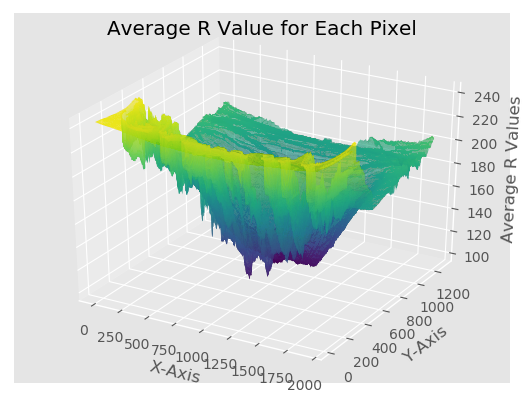

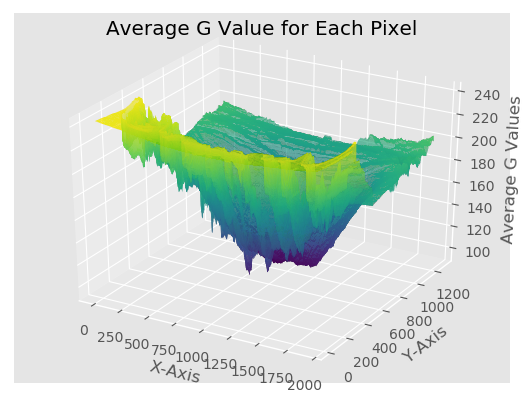

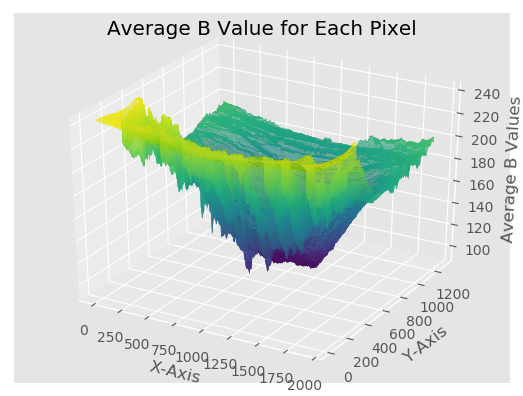

In [5]:
plot_3d_bar_chart(avg_pixel, '3D_HeatMap', type_)

## 3.6 Percentage of Car in Each Images

This shows the total percentage of a car in the each images. A small percentage of car among the image could result in inaccurate results as there is not much car labels to learn from. We found out that more of the images has about 15-35% of car in them. This could shows us that most part of the images are the background and the ground. 



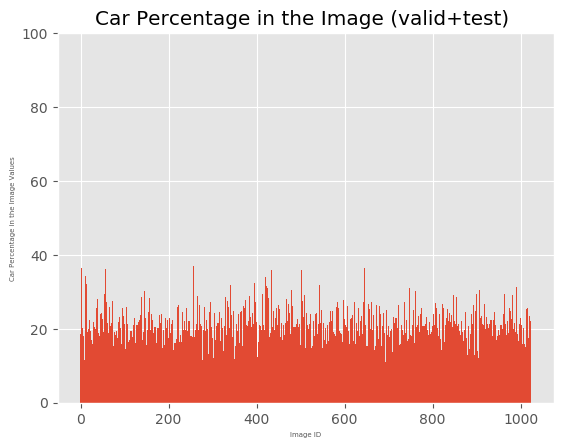

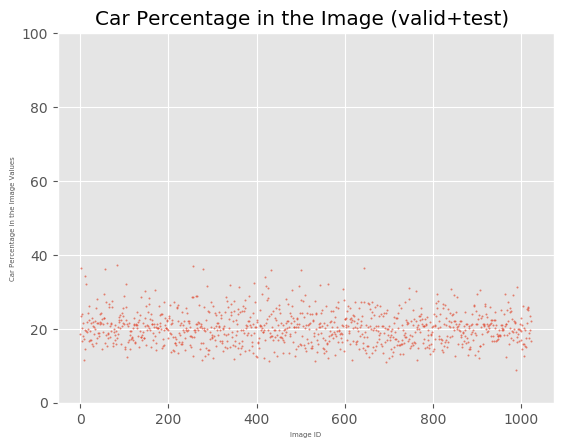

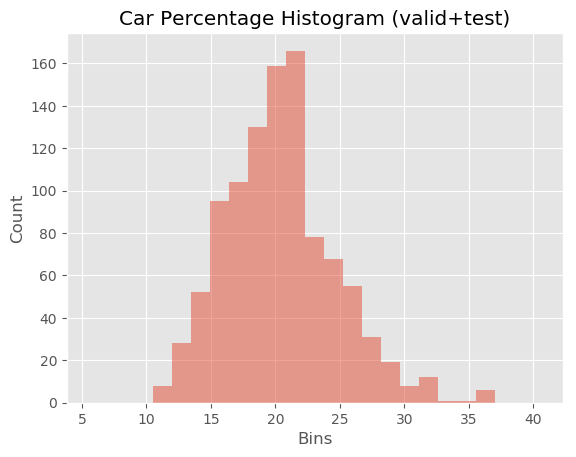

In [7]:
plot_car_percentage(type_, path)

# 4. Pre-processing
Data cleaning (missing features)
Data normalization (unbalanced scaling : max, z-scoring)
Important and consuming step to prepare the data for analysis

# 5. Data analysis with deep learning
Apply deep learning to solve your data problem :
Regression
Classification
Others
Compare different models :


## 5.1 Model selection

The state-of-the-art semantic segmentation method are mainly FCNs-based(fully convolutional networks), Encoder-decoder-based methods. However, they are mainly with large model size and high lantency during inference. (E.g. Deeplab model trained on Cityscapes [xception71_dpc_cityscapes_trainval](https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/model_zoo.md) is <b>439MB</b> and <b>0.25fps ~ 4 seconds</b> per image inference in Cityscapes dataset)

In here, we propose to use the <b>image cascade network(ICNet)</b> to this kaggle challenge, which is able to solve high resolution semantic segmentation problem in real-time(See Figure. 1) with decentquality results. Also, this model has not been implement in kaggle competition before yet, which deals with similar background foreground segmentation and the same object in different angels.

The network architecture is shown in Figure 2, which actually incorporates multi-resolution branches(i.e. low-, medium- and high resolution images branch). While the main computational burden comes from the low resolution branch, the inference time achieves 5 times speed up, and the memory consumption reduces by 5 times also.

 ![ICNET_Comparison](report_fig/ICNET_Comparison.png)
 Figure 1. Inference time versus accuracy in different models

![icnet](report_fig/icnet.png)
Figure 2. ICNET archite-- "ICNet for Real-Time Semantic Segmentation on High-Resolution Images,"


 <center><font color=gray size=0.5> Reference: Zhao, H., Qi, X., Shen, X., Shi, J., & Jia, J. (2017). Icnet for real-time semantic segmentation on high-resolution images. arXiv preprint arXiv:1704.08545(ECCV'18)</font></center>
 
 The 1/4 sized image is fed into PSPNet (a full segmentation backbone) first in the top branch with the complete downsampling and dilated convolution process. Getting the 1/32 predicted feature map, the result is refined from the middle and bottom branches. The layers details will be covered in the following implementation parts. 

In [1]:
from src.network import *
from utils.config import Config
from utils.image_reader import ImageReader, prepare_label

class ICNet_BN(Network):
    def __init__(self, cfg, mode, image_reader=None):
        self.cfg = cfg
        self.mode = mode

        if mode == 'train':
            self.images, self.labels = image_reader.next_image, image_reader.next_label

            super().__init__(inputs={'data': self.images}, cfg=self.cfg)

        elif mode == 'eval':
            self.images, self.labels = image_reader.next_image, image_reader.next_label

            super().__init__(inputs={'data': self.images}, cfg=self.cfg)

            self.output = self.get_output_node()

        elif mode == 'inference':
            # Create placeholder and pre-process here.
            self.img_placeholder = tf.placeholder(dtype=tf.float32, shape=cfg.INFER_SIZE)
            self.images, self.o_shape, self.n_shape = _infer_preprocess(self.img_placeholder,cfg.IMG_MEAN)

            super().__init__(inputs={'data': self.images}, cfg=self.cfg)

            self.output = self.get_output_node()

    def get_output_node(self):
        if self.mode == 'inference':
            # Get logits from final layer
            logits = self.layers['conv6_cls']

            # Upscale the logits and decode prediction to get final result.
            logits_up = tf.image.resize_bilinear(logits, size=self.n_shape, align_corners=True)
            logits_up = tf.image.crop_to_bounding_box(logits_up, 0, 0, self.o_shape[0], self.o_shape[1])

            output_classes = tf.argmax(logits_up, axis=3)
            # output = decode_labels(output_classes, self.o_shape, self.cfg.param['num_classes'])
            output=output_classes
        elif self.mode == 'eval':
            logits = self.layers['conv6_cls']

            logits_up = tf.image.resize_bilinear(logits, size=tf.shape(self.labels)[1:3], align_corners=True)
            output = tf.argmax(logits_up, axis=3)
            output = tf.expand_dims(output, axis=3)

        return output

    def predict(self, image):
        return self.sess.run(self.output, feed_dict={self.img_placeholder: image})

    def setup(self):
        (self.feed('data')
         .interp(s_factor=0.5, name='data_sub2')
         .conv(3, 3, 32, 2, 2, biased=False, padding='SAME', relu=False, name='conv1_1_3x3_s2')
         .batch_normalization(relu=True, name='conv1_1_3x3_s2_bn')
         .conv(3, 3, 32, 1, 1, biased=False, padding='SAME', relu=False, name='conv1_2_3x3')
         .batch_normalization(relu=True, name='conv1_2_3x3_bn')
         .conv(3, 3, 64, 1, 1, biased=False, padding='SAME', relu=False, name='conv1_3_3x3')
         .batch_normalization(relu=True, name='conv1_3_3x3_bn')
         .zero_padding(paddings=1, name='padding0')
         .max_pool(3, 3, 2, 2, name='pool1_3x3_s2')
         .conv(1, 1, 128, 1, 1, biased=False, relu=False, name='conv2_1_1x1_proj')
         .batch_normalization(relu=False, name='conv2_1_1x1_proj_bn'))

        (self.feed('pool1_3x3_s2')
         .conv(1, 1, 32, 1, 1, biased=False, relu=False, name='conv2_1_1x1_reduce')
         .batch_normalization(relu=True, name='conv2_1_1x1_reduce_bn')
         .zero_padding(paddings=1, name='padding1')
         .conv(3, 3, 32, 1, 1, biased=False, relu=False, name='conv2_1_3x3')
         .batch_normalization(relu=True, name='conv2_1_3x3_bn')
         .conv(1, 1, 128, 1, 1, biased=False, relu=False, name='conv2_1_1x1_increase')
         .batch_normalization(relu=False, name='conv2_1_1x1_increase_bn'))

        (self.feed('conv2_1_1x1_proj_bn',
                   'conv2_1_1x1_increase_bn')
         .add(name='conv2_1')
         .relu(name='conv2_1/relu')
         .conv(1, 1, 32, 1, 1, biased=False, relu=False, name='conv2_2_1x1_reduce')
         .batch_normalization(relu=True, name='conv2_2_1x1_reduce_bn')
         .zero_padding(paddings=1, name='padding2')
         .conv(3, 3, 32, 1, 1, biased=False, relu=False, name='conv2_2_3x3')
         .batch_normalization(relu=True, name='conv2_2_3x3_bn')
         .conv(1, 1, 128, 1, 1, biased=False, relu=False, name='conv2_2_1x1_increase')
         .batch_normalization(relu=False, name='conv2_2_1x1_increase_bn'))

        (self.feed('conv2_1/relu',
                   'conv2_2_1x1_increase_bn')
         .add(name='conv2_2')
         .relu(name='conv2_2/relu')
         .conv(1, 1, 32, 1, 1, biased=False, relu=False, name='conv2_3_1x1_reduce')
         .batch_normalization(relu=True, name='conv2_3_1x1_reduce_bn')
         .zero_padding(paddings=1, name='padding3')
         .conv(3, 3, 32, 1, 1, biased=False, relu=False, name='conv2_3_3x3')
         .batch_normalization(relu=True, name='conv2_3_3x3_bn')
         .conv(1, 1, 128, 1, 1, biased=False, relu=False, name='conv2_3_1x1_increase')
         .batch_normalization(relu=False, name='conv2_3_1x1_increase_bn'))

        (self.feed('conv2_2/relu',
                   'conv2_3_1x1_increase_bn')
         .add(name='conv2_3')
         .relu(name='conv2_3/relu')
         .conv(1, 1, 256, 2, 2, biased=False, relu=False, name='conv3_1_1x1_proj')
         .batch_normalization(relu=False, name='conv3_1_1x1_proj_bn'))

        (self.feed('conv2_3/relu')
         .conv(1, 1, 64, 2, 2, biased=False, relu=False, name='conv3_1_1x1_reduce')
         .batch_normalization(relu=True, name='conv3_1_1x1_reduce_bn')
         .zero_padding(paddings=1, name='padding4')
         .conv(3, 3, 64, 1, 1, biased=False, relu=False, name='conv3_1_3x3')
         .batch_normalization(relu=True, name='conv3_1_3x3_bn')
         .conv(1, 1, 256, 1, 1, biased=False, relu=False, name='conv3_1_1x1_increase')
         .batch_normalization(relu=False, name='conv3_1_1x1_increase_bn'))

        (self.feed('conv3_1_1x1_proj_bn',
                   'conv3_1_1x1_increase_bn')
         .add(name='conv3_1')
         .relu(name='conv3_1/relu')
         .interp(s_factor=0.5, name='conv3_1_sub4')
         .conv(1, 1, 64, 1, 1, biased=False, relu=False, name='conv3_2_1x1_reduce')
         .batch_normalization(relu=True, name='conv3_2_1x1_reduce_bn')
         .zero_padding(paddings=1, name='padding5')
         .conv(3, 3, 64, 1, 1, biased=False, relu=False, name='conv3_2_3x3')
         .batch_normalization(relu=True, name='conv3_2_3x3_bn')
         .conv(1, 1, 256, 1, 1, biased=False, relu=False, name='conv3_2_1x1_increase')
         .batch_normalization(relu=False, name='conv3_2_1x1_increase_bn'))

        (self.feed('conv3_1_sub4',
                   'conv3_2_1x1_increase_bn')
         .add(name='conv3_2')
         .relu(name='conv3_2/relu')
         .conv(1, 1, 64, 1, 1, biased=False, relu=False, name='conv3_3_1x1_reduce')
         .batch_normalization(relu=True, name='conv3_3_1x1_reduce_bn')
         .zero_padding(paddings=1, name='padding6')
         .conv(3, 3, 64, 1, 1, biased=False, relu=False, name='conv3_3_3x3')
         .batch_normalization(relu=True, name='conv3_3_3x3_bn')
         .conv(1, 1, 256, 1, 1, biased=False, relu=False, name='conv3_3_1x1_increase')
         .batch_normalization(relu=False, name='conv3_3_1x1_increase_bn'))

        (self.feed('conv3_2/relu',
                   'conv3_3_1x1_increase_bn')
         .add(name='conv3_3')
         .relu(name='conv3_3/relu')
         .conv(1, 1, 64, 1, 1, biased=False, relu=False, name='conv3_4_1x1_reduce')
         .batch_normalization(relu=True, name='conv3_4_1x1_reduce_bn')
         .zero_padding(paddings=1, name='padding7')
         .conv(3, 3, 64, 1, 1, biased=False, relu=False, name='conv3_4_3x3')
         .batch_normalization(relu=True, name='conv3_4_3x3_bn')
         .conv(1, 1, 256, 1, 1, biased=False, relu=False, name='conv3_4_1x1_increase')
         .batch_normalization(relu=False, name='conv3_4_1x1_increase_bn'))

        (self.feed('conv3_3/relu',
                   'conv3_4_1x1_increase_bn')
         .add(name='conv3_4')
         .relu(name='conv3_4/relu')
         .conv(1, 1, 512, 1, 1, biased=False, relu=False, name='conv4_1_1x1_proj')
         .batch_normalization(relu=False, name='conv4_1_1x1_proj_bn'))

        (self.feed('conv3_4/relu')
         .conv(1, 1, 128, 1, 1, biased=False, relu=False, name='conv4_1_1x1_reduce')
         .batch_normalization(relu=True, name='conv4_1_1x1_reduce_bn')
         .zero_padding(paddings=2, name='padding8')
         .atrous_conv(3, 3, 128, 2, biased=False, relu=False, name='conv4_1_3x3')
         .batch_normalization(relu=True, name='conv4_1_3x3_bn')
         .conv(1, 1, 512, 1, 1, biased=False, relu=False, name='conv4_1_1x1_increase')
         .batch_normalization(relu=False, name='conv4_1_1x1_increase_bn'))

        (self.feed('conv4_1_1x1_proj_bn',
                   'conv4_1_1x1_increase_bn')
         .add(name='conv4_1')
         .relu(name='conv4_1/relu')
         .conv(1, 1, 128, 1, 1, biased=False, relu=False, name='conv4_2_1x1_reduce')
         .batch_normalization(relu=True, name='conv4_2_1x1_reduce_bn')
         .zero_padding(paddings=2, name='padding9')
         .atrous_conv(3, 3, 128, 2, biased=False, relu=False, name='conv4_2_3x3')
         .batch_normalization(relu=True, name='conv4_2_3x3_bn')
         .conv(1, 1, 512, 1, 1, biased=False, relu=False, name='conv4_2_1x1_increase')
         .batch_normalization(relu=False, name='conv4_2_1x1_increase_bn'))

        (self.feed('conv4_1/relu',
                   'conv4_2_1x1_increase_bn')
         .add(name='conv4_2')
         .relu(name='conv4_2/relu')
         .conv(1, 1, 128, 1, 1, biased=False, relu=False, name='conv4_3_1x1_reduce')
         .batch_normalization(relu=True, name='conv4_3_1x1_reduce_bn')
         .zero_padding(paddings=2, name='padding10')
         .atrous_conv(3, 3, 128, 2, biased=False, relu=False, name='conv4_3_3x3')
         .batch_normalization(relu=True, name='conv4_3_3x3_bn')
         .conv(1, 1, 512, 1, 1, biased=False, relu=False, name='conv4_3_1x1_increase')
         .batch_normalization(relu=False, name='conv4_3_1x1_increase_bn'))

        (self.feed('conv4_2/relu',
                   'conv4_3_1x1_increase_bn')
         .add(name='conv4_3')
         .relu(name='conv4_3/relu')
         .conv(1, 1, 128, 1, 1, biased=False, relu=False, name='conv4_4_1x1_reduce')
         .batch_normalization(relu=True, name='conv4_4_1x1_reduce_bn')
         .zero_padding(paddings=2, name='padding11')
         .atrous_conv(3, 3, 128, 2, biased=False, relu=False, name='conv4_4_3x3')
         .batch_normalization(relu=True, name='conv4_4_3x3_bn')
         .conv(1, 1, 512, 1, 1, biased=False, relu=False, name='conv4_4_1x1_increase')
         .batch_normalization(relu=False, name='conv4_4_1x1_increase_bn'))

        (self.feed('conv4_3/relu',
                   'conv4_4_1x1_increase_bn')
         .add(name='conv4_4')
         .relu(name='conv4_4/relu')
         .conv(1, 1, 128, 1, 1, biased=False, relu=False, name='conv4_5_1x1_reduce')
         .batch_normalization(relu=True, name='conv4_5_1x1_reduce_bn')
         .zero_padding(paddings=2, name='padding12')
         .atrous_conv(3, 3, 128, 2, biased=False, relu=False, name='conv4_5_3x3')
         .batch_normalization(relu=True, name='conv4_5_3x3_bn')
         .conv(1, 1, 512, 1, 1, biased=False, relu=False, name='conv4_5_1x1_increase')
         .batch_normalization(relu=False, name='conv4_5_1x1_increase_bn'))

        (self.feed('conv4_4/relu',
                   'conv4_5_1x1_increase_bn')
         .add(name='conv4_5')
         .relu(name='conv4_5/relu')
         .conv(1, 1, 128, 1, 1, biased=False, relu=False, name='conv4_6_1x1_reduce')
         .batch_normalization(relu=True, name='conv4_6_1x1_reduce_bn')
         .zero_padding(paddings=2, name='padding13')
         .atrous_conv(3, 3, 128, 2, biased=False, relu=False, name='conv4_6_3x3')
         .batch_normalization(relu=True, name='conv4_6_3x3_bn')
         .conv(1, 1, 512, 1, 1, biased=False, relu=False, name='conv4_6_1x1_increase')
         .batch_normalization(relu=False, name='conv4_6_1x1_increase_bn'))

        (self.feed('conv4_5/relu',
                   'conv4_6_1x1_increase_bn')
         .add(name='conv4_6')
         .relu(name='conv4_6/relu')
         .conv(1, 1, 1024, 1, 1, biased=False, relu=False, name='conv5_1_1x1_proj')
         .batch_normalization(relu=False, name='conv5_1_1x1_proj_bn'))

        (self.feed('conv4_6/relu')
         .conv(1, 1, 256, 1, 1, biased=False, relu=False, name='conv5_1_1x1_reduce')
         .batch_normalization(relu=True, name='conv5_1_1x1_reduce_bn')
         .zero_padding(paddings=4, name='padding14')
         .atrous_conv(3, 3, 256, 4, biased=False, relu=False, name='conv5_1_3x3')
         .batch_normalization(relu=True, name='conv5_1_3x3_bn')
         .conv(1, 1, 1024, 1, 1, biased=False, relu=False, name='conv5_1_1x1_increase')
         .batch_normalization(relu=False, name='conv5_1_1x1_increase_bn'))

        (self.feed('conv5_1_1x1_proj_bn',
                   'conv5_1_1x1_increase_bn')
         .add(name='conv5_1')
         .relu(name='conv5_1/relu')
         .conv(1, 1, 256, 1, 1, biased=False, relu=False, name='conv5_2_1x1_reduce')
         .batch_normalization(relu=True, name='conv5_2_1x1_reduce_bn')
         .zero_padding(paddings=4, name='padding15')
         .atrous_conv(3, 3, 256, 4, biased=False, relu=False, name='conv5_2_3x3')
         .batch_normalization(relu=True, name='conv5_2_3x3_bn')
         .conv(1, 1, 1024, 1, 1, biased=False, relu=False, name='conv5_2_1x1_increase')
         .batch_normalization(relu=False, name='conv5_2_1x1_increase_bn'))

        (self.feed('conv5_1/relu',
                   'conv5_2_1x1_increase_bn')
         .add(name='conv5_2')
         .relu(name='conv5_2/relu')
         .conv(1, 1, 256, 1, 1, biased=False, relu=False, name='conv5_3_1x1_reduce')
         .batch_normalization(relu=True, name='conv5_3_1x1_reduce_bn')
         .zero_padding(paddings=4, name='padding16')
         .atrous_conv(3, 3, 256, 4, biased=False, relu=False, name='conv5_3_3x3')
         .batch_normalization(relu=True, name='conv5_3_3x3_bn')
         .conv(1, 1, 1024, 1, 1, biased=False, relu=False, name='conv5_3_1x1_increase')
         .batch_normalization(relu=False, name='conv5_3_1x1_increase_bn'))

        (self.feed('conv5_2/relu',
                   'conv5_3_1x1_increase_bn')
         .add(name='conv5_3')
         .relu(name='conv5_3/relu'))

        shape = self.layers['conv5_3/relu'].get_shape().as_list()[1:3]
        h, w = shape

        (self.feed('conv5_3/relu')
         .avg_pool(h, w, h, w, name='conv5_3_pool1')
         .resize_bilinear(shape, name='conv5_3_pool1_interp'))

        (self.feed('conv5_3/relu')
         .avg_pool(h / 2, w / 2, h / 2, w / 2, name='conv5_3_pool2')
         .resize_bilinear(shape, name='conv5_3_pool2_interp'))

        (self.feed('conv5_3/relu')
         .avg_pool(h / 3, w / 3, h / 3, w / 3, name='conv5_3_pool3')
         .resize_bilinear(shape, name='conv5_3_pool3_interp'))

        (self.feed('conv5_3/relu')
         .avg_pool(h / 4, w / 4, h / 4, w / 4, name='conv5_3_pool6')
         .resize_bilinear(shape, name='conv5_3_pool6_interp'))

        (self.feed('conv5_3/relu',
                   'conv5_3_pool6_interp',
                   'conv5_3_pool3_interp',
                   'conv5_3_pool2_interp',
                   'conv5_3_pool1_interp')
         .add(name='conv5_3_sum')
         .conv(1, 1, 256, 1, 1, biased=False, relu=False, name='conv5_4_k1')
         .batch_normalization(relu=True, name='conv5_4_k1_bn')
         .interp(z_factor=2.0, name='conv5_4_interp')
         .zero_padding(paddings=2, name='padding17')
         .atrous_conv(3, 3, 128, 2, biased=False, relu=False, name='conv_sub4')
         .batch_normalization(relu=False, name='conv_sub4_bn'))

        (self.feed('conv3_1/relu')
         .conv(1, 1, 128, 1, 1, biased=False, relu=False, name='conv3_1_sub2_proj')
         .batch_normalization(relu=False, name='conv3_1_sub2_proj_bn'))

        (self.feed('conv_sub4_bn',
                   'conv3_1_sub2_proj_bn')
         .add(name='sub24_sum')
         .relu(name='sub24_sum/relu')
         .interp(z_factor=2.0, name='sub24_sum_interp')
         .zero_padding(paddings=2, name='padding18')
         .atrous_conv(3, 3, 128, 2, biased=False, relu=False, name='conv_sub2')
         .batch_normalization(relu=False, name='conv_sub2_bn'))

        (self.feed('data')
         .conv(3, 3, 32, 2, 2, biased=False, padding='SAME', relu=False, name='conv1_sub1')
         .batch_normalization(relu=True, name='conv1_sub1_bn')
         .conv(3, 3, 32, 2, 2, biased=False, padding='SAME', relu=False, name='conv2_sub1')
         .batch_normalization(relu=True, name='conv2_sub1_bn')
         .conv(3, 3, 64, 2, 2, biased=False, padding='SAME', relu=False, name='conv3_sub1')
         .batch_normalization(relu=True, name='conv3_sub1_bn')
         .conv(1, 1, 128, 1, 1, biased=False, relu=False, name='conv3_sub1_proj')
         .batch_normalization(relu=False, name='conv3_sub1_proj_bn'))

        (self.feed('conv_sub2_bn',
                   'conv3_sub1_proj_bn')
         .add(name='sub12_sum')
         .relu(name='sub12_sum/relu')
         .interp(z_factor=2.0, name='sub12_sum_interp')
         .conv(1, 1, self.cfg.param['num_classes'], 1, 1, biased=True, relu=False, name='conv6_cls'))

        (self.feed('conv5_4_interp')
         .conv(1, 1, self.cfg.param['num_classes'], 1, 1, biased=True, relu=False, name='sub4_out'))

        (self.feed('sub24_sum_interp')
         .conv(1, 1, self.cfg.param['num_classes'], 1, 1, biased=True, relu=False, name='sub24_out'))

## 5.2 Training Phase

Before training, we use ImageReader class to load the training dataset with Tensorflow. The ImageReader include the preprossing method we mentioned before.(E.g. Random scaling, Random mirroring)

In our implementation, when the random_mirror parameter is True, the training dataset will be randomly mirror for data augmentation. When the random_scale parameter it Ture, the training dataset will be randomly scale. Also, we follow the epoch training scheme, which enables us to better tune the hyperparameters. Each step cover a mini-batch training, while each epoch go through the whole dataset once. 

In experiment section, we tune all hyperparameters (E.g batch size, $\lambda_{1}$, $\lambda_{2}$, $\lambda_{3}$, etc.) and different data augmentation method, and then evaluate the MIou on the validation set to select the best setting.

Default Training Setting:
* "random_mirror": false
* "random_scale": false
* "BATCH_SIZE": 16,
* "IMG_MEAN": [177.6820068359375,175.83999633789062,174.2100067138672]
* "INFER_SIZE": [1280,1918,3]
* "LAMBDA1": 0.16,
* "LAMBDA2": 0.4,
* "LAMBDA3": 1.0,
* "LEARNING_RATE": 0.0005,
* "MOMENTUM": 0.9,
* "TRAINING_SIZE": [720,720]
* "TRAINING_EPOCHS": 20,
* "WEIGHT_DECAY": 0.0001,
* "eval_size": [1280,1918],
* "eval_steps": 10,
* "filter_scale": 1,
* "ignore_label": 100
* "loss_type": "cross_entropy",
* "model_weight": icnet_cityscapes_train_30k_bnnomerge.npy
* "name": "Kaggle"
* "num_classes": 2


In [2]:
import os
import sys
import argparse
import time
import math
import tensorflow as tf

In [4]:
def get_mask(gt, num_classes, ignore_label):
    less_equal_class = tf.less_equal(gt, num_classes - 1)
    not_equal_ignore = tf.not_equal(gt, ignore_label)
    mask = tf.logical_and(less_equal_class, not_equal_ignore)
    indices = tf.squeeze(tf.where(mask), 1)

    return indices

## Softmax Cross Entropy Loss:

For one single image:

<img src="http://chart.googleapis.com/chart?cht=tx&chl=\Large Loss=-\frac{1}{{X_t}\cdot{Y_t}}\sum_{y=1}^{Y_t}\sum_{x=1}^{X_t}\log{\frac{{e^{f^{t}_{\tilde{n},y,x}}}}{\sum_{n=1}^{N}{e^{f^{t}_{n,y,x}}}}" style="border:none;">

Where x,y represent the row,col index of the image.n is the classification result for each class, while $\tilde{n}$ is the correct class classification prbability.

In [5]:
"""Define the Cross Entropy Loss in pixel level
        Args:
        output: Prediction Output
        label: Ground truth Label
        num_classes: number of classes
        ignore_label: label not to include in prediction
        Returns:
        Cross Entropy Loss
        """
def create_loss(output, label, num_classes, ignore_label):
        
    raw_pred = tf.reshape(output, [-1, num_classes])
    label = prepare_label(label, tf.stack(output.get_shape()[1:3]), num_classes=num_classes, one_hot=False)
    label = tf.reshape(label, [-1, ])

    indices = get_mask(label, num_classes, ignore_label)
    gt = tf.cast(tf.gather(label, indices), tf.int32)
    pred = tf.gather(raw_pred, indices)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=pred, labels=gt)
    reduced_loss = tf.reduce_mean(loss)

    return reduced_loss


## Binary Cross Entropy + DICE Coefficient Loss:

BCE definition:

<img src="http://chart.googleapis.com/chart?cht=tx&chl=\Large BCE=-\sum_{y=1}^{Y_t}\sum_{x=1}^{X_t}({f^{t}_{\tilde{n},y,x}\cdot{\log{f^{t}_{n,y,x}}}%2B (1-f^{t}_{\tilde{n},y,x})\cdot\log{{{f^{t}_{n,y,x}}})" style="border:none;">

DICE Coefficient Definition:

<img src="http://chart.googleapis.com/chart?cht=tx&chl=\Large DICE=\frac{2*|X\bigcap{Y}|}{|X|%2B|Y|}" style="border:none;">
which is two times intersection over union.

In here, we combine BCE with DICE coefficient in the following formula:

<img src="http://chart.googleapis.com/chart?cht=tx&chl=\Large Loss=BCE-In(DICE)" style="border:none;">


In [6]:
def dice_coef_theoretical(y_pred, y_true):
    """Define the dice coefficient
        Args:
        y_pred: Prediction
        y_true: Ground truth Label
        Returns:
        Dice coefficient
        """

    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)

    y_pred_f = tf.nn.softmax(y_pred)
    y_pred_f = tf.argmax(y_pred_f, axis=1)
    y_pred_f = tf.cast(tf.reshape(y_pred_f, [-1]), tf.float32)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice = (2. * intersection) / (union + 0.00001)

    if (tf.reduce_sum(y_pred) == 0) and (tf.reduce_sum(y_true) == 0):
        dice = 1

    return dice

In [7]:
def create_bce_loss(output, label, num_classes, ignore_label):
    """Define the customized loss in pixel level
        Args:
        output: Prediction Output
        label: Ground truth Label
        num_classes: number of classes
        ignore_label: label not to include in prediction
        Returns:
        Binary Cross Entropy + DICE Coefficient Loss
        """
    raw_pred = tf.reshape(output, [-1, num_classes])
    label = prepare_label(label, tf.stack(output.get_shape()[1:3]), num_classes=num_classes, one_hot=False)
    label = tf.reshape(label, [-1, ])

    indices = get_mask(label, num_classes, ignore_label)
    gt = tf.cast(tf.gather(label, indices), tf.int32)
    gt_one_hot = tf.one_hot(gt, num_classes)
    pred = tf.gather(raw_pred, indices)
    BCE = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=gt_one_hot))

    dice = dice_coef_theoretical(pred, gt)
    loss = BCE - tf.math.log(dice)
    reduced_loss = loss

    return reduced_loss

## Combine losses from three branches:
<img src="http://chart.googleapis.com/chart?cht=tx&chl=\Large L=\sum_{t=1}^{T}\lambda_{t}Loss_t}" style="border:none;">

In our case, T is equal to 3, which is with original resolution input image, medium resolution input image(downsampled by factor 2) and low resolution input image(downsampled by factor 4). $\lambda_{1}$, $\lambda_{2}$ and $\lambda_{3}$ are the weights when we combines the loss from these branches, thus, the total loss will be the weighted sum of three branches loss.

In addition, the main computational burden is in the first branch(low resolution branch), which go through the whole segmentation backbone network (50+ layers PSPNet). See Figure 2.

In [8]:
def create_losses(net, label, cfg):
    # Get output from different branches
    sub4_out = net.layers['sub4_out']
    sub24_out = net.layers['sub24_out']
    sub124_out = net.layers['conv6_cls']

    loss_sub4 = create_loss(sub4_out, label, cfg.param['num_classes'], cfg.param['ignore_label'])
    loss_sub24 = create_loss(sub24_out, label, cfg.param['num_classes'], cfg.param['ignore_label'])
    loss_sub124 = create_loss(sub124_out, label, cfg.param['num_classes'], cfg.param['ignore_label'])

    l2_losses = [cfg.WEIGHT_DECAY * tf.nn.l2_loss(v) for v in tf.trainable_variables() if 'weights' in v.name]

    # Calculate weighted loss of three branches, you can tune LAMBDA values to get better results.
    reduced_loss = cfg.LAMBDA1 * loss_sub4 + cfg.LAMBDA2 * loss_sub24 + cfg.LAMBDA3 * loss_sub124 + tf.add_n(l2_losses)

    return loss_sub4, loss_sub24, loss_sub124, reduced_loss

## Training Configuration Setting

In [9]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
lr_list = [5e-4, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2]
bs_list = [256, 128, 64]
lambda_list = [
        [0.16, 0.4, 1.0],

        [0.16, 0.5, 1.0],
        [0.16, 0.3, 1.0],

        [0.20, 0.4, 1.0],
        [0.12, 0.4, 1.0],

        [0.16, 0.4, 1.2],
        [0.16, 0.4, 0.8],
    ]
LAMBDA1 = lambda_list[0]
LAMBDA2 = lambda_list[1]
LAMBDA3 = lambda_list[2]
BATCH_SIZE = 16
LEARNING_RATE = 5e-4
random_scale=False
random_mirror=False
train_beta_gamma=True
update_mean_var=False
filter_scale=1
dataset='others'
INFER_SIZE = [1280, 1918, 3]

## Create Train Config Class

In [10]:
class TrainConfig(Config):
    def __init__(self, dataset, is_training, filter_scale=1, random_scale=None, random_mirror=None, log_path_end='',INFER_SIZE=None):
        Config.__init__(self, dataset, is_training, filter_scale, random_scale, random_mirror,
                        log_path_end=log_path_end,INFER_SIZE=INFER_SIZE)

    # Set pre-trained weights here (You can download weight using `python script/download_weights.py`) 
    # Note that you need to use "bnnomerge" version.
    #model_weight = '../model/cityscapes/icnet_cityscapes_train_30k_bnnomerge.npy'

    # Set hyperparameters here, you can get much more setting in Config Class, see 'utils/config.py' for details.
    LAMBDA1 = 0.16
    LAMBDA2 = 0.4
    LAMBDA3 = 1.0
    
    BATCH_SIZE = 1
    LEARNING_RATE = 5e-4
    

## Train session

Here, we start a example training session with the default training configuration setting. Each training session will cost 4-5 hours.

In [23]:
def train(lr=None, log_path_end='', bs=None, lambda_list=None):
    """Create the model and start the training."""
    tf.reset_default_graph()
    

    """
    Get configurations here. We pass some arguments from command line to init configurations, for training hyperparameters, 
    you can set them in TrainConfig Class.

    Note: we set filter scale to 1 for pruned model, 2 for non-pruned model. The filters numbers of non-pruned
          model is two times larger than prunde model, e.g., [h, w, 64] <-> [h, w, 32].
    """
    cfg = TrainConfig(dataset=dataset,
                      is_training=True,
                      random_scale=random_scale,
                      random_mirror=random_mirror,
                      filter_scale=filter_scale,
                      log_path_end=log_path_end,INFER_SIZE=INFER_SIZE)
    if lr:
        cfg.LEARNING_RATE = lr
    if bs:
        cfg.BATCH_SIZE = bs

    if lambda_list:
        cfg.LAMBDA1 = lambda_list[0]
        cfg.LAMBDA2 = lambda_list[1]
        cfg.LAMBDA3 = lambda_list[2]

    cfg.display()

    # Setup training network and training samples
    train_reader = ImageReader(cfg=cfg, mode='train')
    train_net = ICNet_BN(image_reader=train_reader,
                         cfg=cfg, mode='train')

    loss_sub4, loss_sub24, loss_sub124, reduced_loss = create_losses(train_net, train_net.labels, cfg)

    # Setup validation network and validation samples

    with tf.variable_scope('', reuse=True):
        val_reader = ImageReader(cfg, mode='eval')
        val_net = ICNet_BN(image_reader=val_reader,
                           cfg=cfg, mode='train')

        val_loss_sub4, val_loss_sub24, val_loss_sub124, val_reduced_loss = create_losses(val_net, val_net.labels, cfg)

    # Using Poly learning rate policy 
    base_lr = tf.constant(cfg.LEARNING_RATE)
    step_ph = tf.placeholder(dtype=tf.float32, shape=())
    learning_rate = tf.scalar_mul(base_lr, tf.pow((1 - step_ph / cfg.TRAINING_EPOCHS), cfg.POWER))
    # learning_rate = base_lr

    # Set restore variable
    restore_var = tf.global_variables()
    #restore_var = [v for v in tf.global_variables() if 'conv6_cls' not in v.name]
    all_trainable = [v for v in tf.trainable_variables() if
                     ('beta' not in v.name and 'gamma' not in v.name) or train_beta_gamma]

    # Gets moving_mean and moving_variance update operations from tf.GraphKeys.UPDATE_OPS
    if update_mean_var == False:
        update_ops = None
    else:
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    with tf.control_dependencies(update_ops):
        opt_conv = tf.train.MomentumOptimizer(learning_rate, cfg.MOMENTUM)
        grads = tf.gradients(reduced_loss, all_trainable)
        train_op = opt_conv.apply_gradients(zip(grads, all_trainable))

    # Create session & restore weights (Here we only need to use train_net to create session since we reuse it)
    train_net.create_session()
    #train_net.restore(cfg.model_weight, restore_var)
    saver = tf.train.Saver(var_list=tf.global_variables(), max_to_keep=5)

    # Iterate over training steps.
    train_info = []
    iter_max = math.ceil(cfg.param['total_train_sample'] / cfg.BATCH_SIZE)
    try:
        for epoch in range(cfg.TRAINING_EPOCHS):
            feed_dict = {step_ph: epoch}
            for iter in range(iter_max):
                start_time = time.time()
                loss_value, loss1, loss2, loss3, val_loss_value, _ = train_net.sess.run(
                    [reduced_loss, loss_sub4, loss_sub24, loss_sub124, val_reduced_loss, train_op],
                    feed_dict=feed_dict)
                duration = time.time() - start_time
                log = {
                    'LOSS_VALUE': float(loss_value),
                    'LOSS_1': float(loss1),
                    'LOSS_2': float(loss2),
                    'LOSS_3': float(loss3),
                    'VALIDATION_LOSS_VALUE': float(val_loss_value),
                    'DURATION': float(duration),
                    'STEP': int(iter),
                    'EPOCH': int(epoch),
                }
                train_info.append(log)
                print(
                    'epoch {:d} step {:d} \t total loss = {:.3f}, sub4 = {:.3f}, sub24 = {:.3f}, sub124 = {:.3f}, val_loss: {:.3f} ({:.3f} sec/step)'. \
                        format(epoch, iter, loss_value, loss1, loss2, loss3, val_loss_value, duration))
            if (epoch + 1) % cfg.SAVE_PRED_EVERY == 0:
                train_net.save(saver, cfg.SNAPSHOT_DIR, epoch)

    except KeyboardInterrupt:
        Config.save_to_json(dict=train_info, path=cfg.SNAPSHOT_DIR, file_name='loss.json',mode='eval')
        print("loss.json was saved at %s" % cfg.SNAPSHOT_DIR)
    Config.save_to_json(dict=train_info, path=cfg.SNAPSHOT_DIR, file_name='loss.json',mode='eval')
    print("loss.json was saved at %s" % cfg.SNAPSHOT_DIR)
    sess = tf.get_default_session()
    if sess:
        sess._exit__(None, None, None)

In [ ]:
train()

Setup configurations...

Configurations:
BATCH_SIZE                     1
IMG_MEAN                       [177.682 175.84  174.21 ]
INFER_SIZE                     [1280, 1918, 3]
Kaggle_DATA_DIR                /home/hewei/PycharmProjects/CE7454_Project_Fall2018_NTU/data
Kaggle_eval_list               /home/hewei/PycharmProjects/CE7454_Project_Fall2018_NTU/data/list/valid.txt
Kaggle_train_list              /home/hewei/PycharmProjects/CE7454_Project_Fall2018_NTU/data/list/train.txt
LAMBDA1                        0.16
LAMBDA2                        0.4
LAMBDA3                        1.0
LEARNING_RATE                  0.0005
MOMENTUM                       0.9
N_WORKERS                      8
POWER                          0.9
RANDOM_SEED                    329906443
SAVE_NUM_IMAGES                4
SAVE_PRED_EVERY                2
SNAPSHOT_DIR                   /home/hewei/PycharmProjects/CE7454_Project_Fall2018_NTU/log/2018-11-15_03-24-24_
TRAINING_EPOCHS                20
TRAINING_SIZE   

## 5.3 Evaluation Phase

In here, after each training session, we evaluate our model in validation dataset, which includes 1024 images. The evaluation metric is MIOU:

<img src="http://chart.googleapis.com/chart?cht=tx&chl=\Large MIOU=AVG(IOU)" style="border:none;">

![iou](report_fig/iou_equation.png)



In [30]:
model='others'
dataset='others'
model_type='others'
filter_scale=1
model_config = {'train': ICNet_BN, 'trainval': ICNet_BN, 'train_bn': ICNet_BN, 'trainval_bn': ICNet_BN, 'others': ICNet_BN}
IMG_MEAN = np.array((177.682, 175.84, 174.21), dtype=np.float32)
INFER_SIZE = [1280, 1918, 3]

filter_scale=1
from log import LOG_PATH
from log import LOG_PATH
import argparse
import tensorflow as tf
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import trange
from utils.config import Config
import torch

import tensorflow as tf
from src.network import Network
from utils.image_reader import _infer_preprocess

from utils.visualize import decode_labels
from src.TernausNet import Example
from src.TernausNet.Example import get_model

In [31]:
def _extract_mean_revert(img, img_mean, swap_channel=False):
    # swap channel and extract mean
    img += img_mean
    if swap_channel:
        img_b = img[:, :, 0]
        img_g = img[:, :, 1]
        img_r = img[:, :, 2]

        img_b = img_b[:, :, np.newaxis]
        img_r = img_r[:, :, np.newaxis]
        img_g = img_g[:, :, np.newaxis]

        img = np.concatenate((img_r, img_g, img_b), axis=2)

    return img

def load_single_image(img_path,cfg):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img.shape != cfg.INFER_SIZE:
        img = cv2.resize(img, (cfg.INFER_SIZE[1], cfg.INFER_SIZE[0]))

    return img

In [34]:
def evaluate(model_log_dir, check_point,mode):
    tf.reset_default_graph()
    print('mode:{}'.format(mode))
    if mode=='eval' or mode=='compute_speed':


        cfg = Config(dataset=dataset,
                     is_training=False,
                     filter_scale=filter_scale,
                     eval_path_log=os.path.join(LOG_PATH, model_log_dir))
        cfg.model_paths['others'] = os.path.join(LOG_PATH, model_log_dir, 'model.ckpt-%d' % check_point)
        cfg.others_param['eval_steps']=10
        model = model_config[model_type]

        reader = ImageReader(cfg=cfg, mode='eval')
        net = ICNet_BN(image_reader=reader, cfg=cfg, mode='eval')

        # mIoU
        pred_flatten = tf.reshape(net.output, [-1, ])
        label_flatten = tf.reshape(net.labels, [-1, ])

        mask = tf.not_equal(label_flatten, cfg.param['ignore_label'])
        indices = tf.squeeze(tf.where(mask), 1)
        gt = tf.cast(tf.gather(label_flatten, indices), tf.int32)
        pred = tf.gather(pred_flatten, indices)

        mIoU, update_op = tf.metrics.mean_iou(predictions=pred, labels=gt, num_classes=cfg.param['num_classes'])

        net.create_session()
        net.restore(cfg.model_paths[model_type])


        duration=0

        for i in trange(cfg.param['eval_steps'], desc='evaluation', leave=True):

            start=time.time()
            _,res, input,labels,out = net.sess.run([update_op,pred, net.images,net.labels,net.output])
            end=time.time()

            duration+=(end-start)
            t_model = get_model()
            input = np.squeeze(input)
            n_input = _extract_mean_revert(input, IMG_MEAN, swap_channel=True)
            n_input = n_input.astype(np.uint8)
            input_image = Image.fromarray(n_input, 'RGB')

            '''tnet -> tnet's predict either 0 1'''
            res2,tnet_mask = Example.ternauNet(n_input,t_model)
            tnet = Image.fromarray((tnet_mask * 255).astype(np.uint8))
            res2 = np.reshape(res2, [-1])
            
            
            if i % 100 == 0:
            
                # save_pred_to_image(res=res,
                #                    shape=cfg.param['eval_size'],
                #                    save_path=os.path.dirname(cfg.model_paths['others']) + '/eval_img',
                #                    save_name='eval_%d_img.png' % i)
            
            
            
                '''res-> network predict either 0 or 1 on each element '''
                icnet = np.array(np.reshape(res, cfg.param['eval_size']), dtype=np.uint8) * 255
                icnet = Image.fromarray(icnet.astype(np.uint8))
                labels = np.squeeze(labels) * 255
                labels = Image.fromarray(labels.astype(np.uint8))
                fig, ax1 = plt.subplots(figsize=(80, 13))
            
                plot1=plt.subplot(141)
                plot1.set_title("Input Image",fontsize=50)
                plt.imshow(input_image)
                plt.axis('off')
            
                plot2=plt.subplot(142)
                plot2.set_title("Ground Truth Mask",fontsize=50)
                plt.imshow(labels, cmap='gray')
                plt.axis('off')
            
                plot3=plt.subplot(143)
                plot3.set_title("Our Result",fontsize=50)
                plt.imshow(icnet, cmap='gray')
                plt.axis('off')
            
                plot4=plt.subplot(144)
                plot4.set_title("TernausNet's Result",fontsize=50)
                plt.imshow(tnet, cmap='gray')
                plt.axis('off')
            
            
                plt.show()

                save_comparation_path = os.path.dirname(cfg.model_paths['others']) + '/eval_compare'
                if os.path.exists(save_comparation_path) is False:
                    os.mkdir(save_compaation_path)
                plt.savefig(os.path.join(save_comparation_path, 'eval_%d_img.png' % i))


        final_mIou = net.sess.run(mIoU)
        print('total time:{} mean inference time:{} mIoU: {}'.format(duration,duration/cfg.param['eval_steps'],final_mIou))

        Config.save_to_json(dict={'FINAL_MIOU': float(final_mIou), "EVAL_STEPS": cfg.param['eval_steps']},
                            path=os.path.dirname(cfg.model_paths['others']),
                            file_name='eval.json',mode=mode)

mode:eval
Setup configurations...
/home/hewei/PycharmProjects/CE7454_Project_Fall2018_NTU/data/list/valid.txt
INFO:tensorflow:Restoring parameters from /home/hewei/PycharmProjects/CE7454_Project_Fall2018_NTU/log/2018-11-08_13-21-26_restore_nonaug/model.ckpt-19


evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Restore from /home/hewei/PycharmProjects/CE7454_Project_Fall2018_NTU/log/2018-11-08_13-21-26_restore_nonaug/model.ckpt-19


/home/hewei/anaconda3/envs/icnet/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


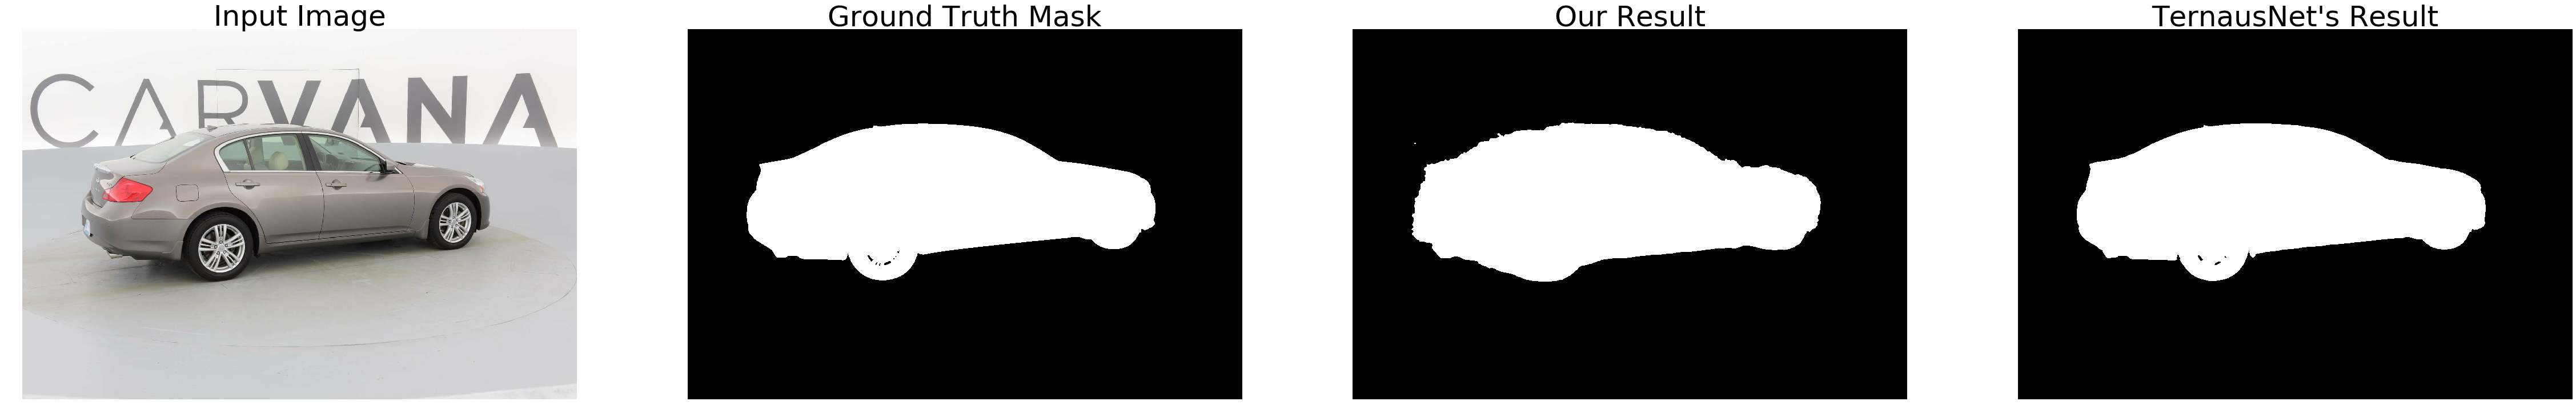

evaluation: 100%|██████████| 10/10 [17:06<00:00, 73.05s/it]


total time:87.72133016586304 mean inference time:8.772133016586304 mIoU: 0.9454805850982666


<Figure size 432x288 with 0 Axes>

In [35]:
evaluate(model_log_dir='2018-11-08_13-21-26_restore_nonaug',check_point=19,mode='eval')

## 5.4 Inference Phase

This competition is evaluated on the mean Dice coefficient. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by:

2∗|X∩Y||X|+|Y|,
where X is the predicted set of pixels and Y is the ground truth. The Dice coefficient is defined to be 1 when both X and Y are empty. The leaderboard score is the mean of the Dice coefficients for each image in the test set.

<img src="http://chart.googleapis.com/chart?cht=tx&chl=\Large x=\frac{-b\pm\sqrt{b^2-4ac}}{2a}" style="border:none;">

In [37]:
from log import LOG_PATH
import argparse
import tensorflow as tf
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import trange
from utils.config import Config
import torch

import tensorflow as tf
from src.network import Network
from utils.image_reader import _infer_preprocess
from utils.visualize import decode_labels

In [38]:
def _extract_mean_revert(img, img_mean, swap_channel=False):
    # swap channel and extract mean
    img += img_mean
    if swap_channel:
        img_b = img[:, :, 0]
        img_g = img[:, :, 1]
        img_r = img[:, :, 2]

        img_b = img_b[:, :, np.newaxis]
        img_r = img_r[:, :, np.newaxis]
        img_g = img_g[:, :, np.newaxis]

        img = np.concatenate((img_r, img_g, img_b), axis=2)

    return img

def load_single_image(img_path,cfg):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img.shape != cfg.INFER_SIZE:
        img = cv2.resize(img, (cfg.INFER_SIZE[1], cfg.INFER_SIZE[0]))

    return img

In [39]:
def run_length_encode(mask):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    inds = mask.flatten()
    mask[0] = 0
    mask[-1] = 0
    runs = np.where(inds[1:] != inds[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    if len(runs) % 2 != 0:
        runs = list(runs)
        runs.append(len(inds) - runs[-1])
        assert runs[-1] <= len(inds)
    rle = ' '.join([str(r) for r in runs])
    return rle

In [40]:
model_config = {'train': ICNet_BN, 'trainval': ICNet_BN, 'train_bn': ICNet_BN, 'trainval_bn': ICNet_BN, 'others': ICNet_BN}
IMG_MEAN = np.array((177.682, 175.84, 174.21), dtype=np.float32)
INFER_SIZE = [1280, 1918, 3]
dataset='others'
model_type='others'
filter_scale=1

In [41]:
def inference(model_log_dir, check_point,mode,img_path=None,testdir=None,submit=False):
    tf.reset_default_graph()
    print('mode:{},model_log:{}'.format(mode,model_log_dir))
    print(os.path.join(LOG_PATH, model_log_dir))
    print(os.path.join(LOG_PATH, model_log_dir, 'model.ckpt-%d' % check_point))
    N = len(list(os.listdir(testdir)))
    '''inference mode'''
    
    cfg = Config(dataset=dataset,
                 is_training=False,
                 filter_scale=filter_scale,
                 eval_path_log=os.path.join(LOG_PATH, model_log_dir),INFER_SIZE = INFER_SIZE)
    cfg.model_paths['others'] = os.path.join(LOG_PATH, model_log_dir, 'model.ckpt-%d' % check_point)

    net = ICNet_BN(cfg=cfg, mode='inference')

    net.create_session()
    net.restore(cfg.model_paths[model_type])

    if submit==False:
        image1=load_single_image(img_path,cfg)
        results1 = net.predict(image1)
        results1=np.squeeze(results1)
        
        results=cv2.cvtColor((results1*255).astype(np.uint8),cv2.COLOR_GRAY2RGB)

        '''Comparison'''

        overlap_results1 = 0.5 * image1 + 0.5 * results

        plt.figure(figsize=(60, 15))

        plot1 = plt.subplot(131)

        plot1.set_title("Input Image",fontsize=50)
        plt.imshow(image1)
        plt.axis('off')

        plot2=plt.subplot(132)
        plot2.set_title("Predicted Mask",fontsize=50)
        plt.imshow(results)
        plt.axis('off')

        plot3=plt.subplot(133)
        plot3.set_title("Mask over image",fontsize=50)
        plt.imshow(overlap_results1/ 255.0)
        plt.axis('off')


        plt.show()

    else:
        with open('SUBMISSION.csv', 'w') as f:
            f.write('img,rle_mask\n')
            duration=0
            for index, i in enumerate(os.listdir(testdir)):
                img = Image.open(os.path.join(testdir ,i))

                start = time.time()

                icnet_predict = net.predict(img)

                stop = time.time()

                duration+=(stop-start)
                mask_array =np.squeeze(icnet_predict)

                plt.imshow(mask_array)
                plt.show()
                en = run_length_encode(mask_array)
                print('{}/{} cost:{}s'.format(index, N, str(stop - start)))
                if i.find('.jpg')!=-1:
                    print('i is {}'.format(i))
                    f.write('{},{}\n'.format(i, en))
                    f.flush()
                else:
                    print('i is {}, not .jpg, exit now!'.format(i))
                    exit()


            mean_inference_time=duration/(index+1)

        Config.save_to_json(
            dict={'Test set size':N,'Test set path':testdir,'Total Inference Time': float(duration), "Mean Inference Time": mean_inference_time},
            path=os.path.dirname(cfg.model_paths['others']),
            file_name='inference.json', mode=mode)

mode:inference,model_log:2018-11-08_13-21-26_restore_nonaug
/home/hewei/PycharmProjects/CE7454_Project_Fall2018_NTU/log/2018-11-08_13-21-26_restore_nonaug
/home/hewei/PycharmProjects/CE7454_Project_Fall2018_NTU/log/2018-11-08_13-21-26_restore_nonaug/model.ckpt-19
Setup configurations...
Image shape cannot divided by 32, padding to (1312, 1920)
INFO:tensorflow:Restoring parameters from /home/hewei/PycharmProjects/CE7454_Project_Fall2018_NTU/log/2018-11-08_13-21-26_restore_nonaug/model.ckpt-19
Restore from /home/hewei/PycharmProjects/CE7454_Project_Fall2018_NTU/log/2018-11-08_13-21-26_restore_nonaug/model.ckpt-19


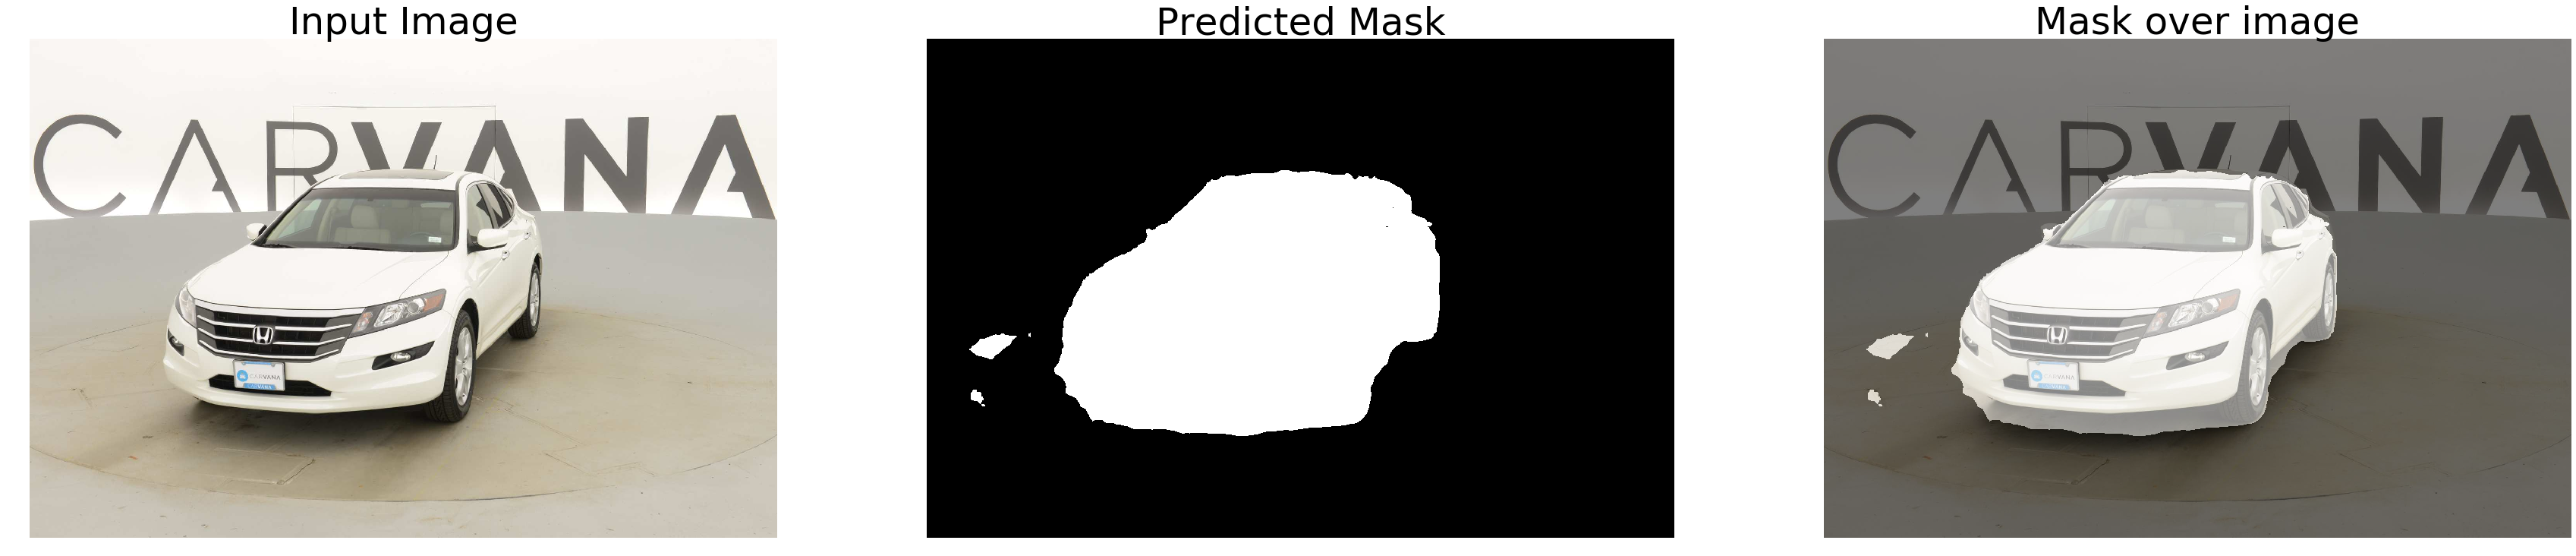

In [44]:
from data import DATA_PATH
dir = '/'
test_image=DATA_PATH+'/Kaggle/valid/data/0d3adbbc9a8b_02.jpg'
inference(model_log_dir='2018-11-08_13-21-26_restore_nonaug', check_point=19,mode='inference',img_path=test_image,testdir=dir,submit=False
     )

## 5.4 Experiment

### Hyper-parameter tuning 


In order to get the best hyper-paramters, in the experiments process, we firstly start the hyper-paramters searching process. 
We focus on tuning the learning rate, lamda (the loss weight in IC net), and the training epochs. Speficially, 
we run the experiments with following paramters:


| Learning Rate     | Lambda1-3   | Training Epoch  |
| :--------: |:-------------:| :-----:|
| 0.05      | (0.16, 0.40, 1.0) | 200 |
| 0.01      | (0.16, 0.50, 1.0)      | 100 |
| 0.005 | (0.16, 0.30, 1.0)      | 80 |
| 0.001 | (0.20, 0.40, 1.0)      | 40 |
| 0.0005 | (0.12, 0.40, 1.0)      | 20 |
| 0.0001 | (0.16, 0.40, 1.0)      | 10 |
|  | (0.16, 0.40, 1.2)      | 5 |
|  | (0.16, 0.40, 0.8)      ||

For the tuning of learning rate, we compare its mIoU on validation set, and the learning rate with 0.0005 reached the 
highest mIoU.  
![learning rate bar](report_fig/miou_bar_lr.jpg)

![learning rate curve](report_fig/miou_line_lr.jpg)

And for the tuning of lambda, we get the following results, and the best setting of lambda is (0.16, 0.30, 1.0)
![lambda rate bar](report_fig/miou_bar_lambda.jpg)

For the tuning of learning, not only we aim to find the best setting of leanring, we also try to detect 
whether over-fitting/under-fitting happens with different training epochs by comparing the curve of training loss 
and validation loss. 
![epoch bar](report_fig/miou_bar_epoch.jpg)

![epoch curve](report_fig/miou_line_epoch.jpg)

The best training epoch is 200.

And the following figure show the comparing of training loss and validation loss under different setting of epoch.

Epoch = 5

![epoch5](report_fig/epoch_5.jpg)

Epoch = 40

![epoch40](report_fig/epoch_40.jpg)

Epoch = 100 

![epoch100](report_fig/epoch_100.jpg)

Epoch = 200

![epoch200](report_fig/epoch_200.jpg)

 ### Modification on Loss Function

In segmentation problem, especially in multi-class segmentation problem, the cross-entropy loss is commonly used, which 
is also being adopted in the IC-net model. But in Caravana Image Masking Challenge, since we aim to solve a binary 
segmentation problem, therefore, the DICE coefficient loss can be used which may improve the overall performance of the
model.

We compare the performance of two different loss functions:

![loss compare](report_fig/loss_compare.jpg)
 
The performance is a little bite degraded using modified loss, by referring the results we get from the data exploring process, this 
maybe attribute to the dataset is quite clean, and the ratio of a car in the whole picture is quite balanced, so the 
dice coefficent loss did not bring too much benefits.

### Train From Scratch or Using Pre-Trained Model
In our training flow, we use the IC-net pre-trained model that was trained on cityscapes dataset. Using a pre-trained 
model is a very common method to boost the training process by giving the model a quite good initial weight. Then we
apply the pre-trained model on our Carvana Image Masking Challenge dataset. Also, we compare this method with the
training from scratch manner.

![train flow compare](report_fig/train_flow.jpg)

The results show a huge performance improvement on using pre-trained model. This may be conducted by that deep learning 
method always required long time of training and huge amount of training data when using a single model. Therefore,
training from scratch show a very poor performance.

### Use Tuned Hyper-parameter for training.
After the previous training phase, we select the hyper-parameter that demonstrate the best result and combine them to 
conduct one experiments. As the previous tuning results showed, we set the learning rate to 0.0005, lambda to (0.16, 0.30., 1.0) and the 
training epoch to 200.

After the training, the mIoU on validation set is improved from 0.900405645 to 0.90815865.
![tuned hyper parameter](report_fig/best_hyper.jpg)
The reason of lacking of large improvement may caused by the fact that the different hyper-parameter may have a inter-influence between each other. We may conduct a more concise way to do the hyper-parameter searching process, starting by the most important hyper-parameter, then the next one.

### Data Augmentation 
In the training dataset, we only have around 5,000 images, whereas in the test set, we have around 10,000 images. In 
order to solve the limited train data, we adopted the data augmentation method in our experiments. We apply the random 
mirroring method and random scaling method to the original dataset and conduct the following experiments.

Instead of directly mixing the augmentation dataset into the original dataset, we use them in the way that, for instance, under the 
setting of n training epochs, we use the original dataset in the first x training epoch, in the rest y epochs, we use 
the augmentation dataset for training.

Specifically, we conduct the following experiments:

|              | Experiment 1 | Experiment 2 | Experiment 3 | 
| :----------: | :----------: | :----------: | :----------: |
| Stage 1      | Original 10 epoch| Original 10 epoch| Original 10 epoch|
| Stage 2      | Random Mirror 10 epoch| Random Scale 10 epoch| Random Scale 5 epcoch|
| Stage 3      |        |        |  Random Mirror 5 Epoch|

And we get the following results:

![data augmentation](report_fig/augmentation.jpg)

In one of the experiments, we get a better result. The augmentation will change the distribution of the original dataset, if the validation set has a similar distribution and the training epoch 10 is not enough, which will lead to the degradation of the performance. So only in one out of three experiments, we have a better result.

### Ensemble Method
To further improve the performance, we use the most common ensemble method that is wildly used in Kaggle Competition. 
To the best of our knowledge. the [TernausNet](https://arxiv.org/abs/1801.05746) is one of the state-of-art segmentation model that even specifically 
designed for the Kaggle Carvana dataset. We use the naive ensemble method by comuting the weighted average of the 
probability of labels given by two models' output, and use this as the final output.

Let the a, b denote the weights and a + b = 1.0, let x denote the output probability on car label of IC-net and y denote
the probability on car label of TernausNet. The ensemble output z = a * x + b * y. And if z > 0.5, the corresponding 
pixel is predicted to be the car, otherwise is background.

We ensemble the TernausNet with different models that are retrieved from our previous experiments results. 
By trying different weight from (0.4, 0.6), (0.5, 0.5), and select the best one. 

The following figure show the result of ensemble method:

![ensemble one](report_fig/ensemble.jpg)

There is a very significant improvement as our expected. Moreover, we visualize some results to show this improvement.

![ensemble result](report_fig/ensemble_1.jpg)
![ensemble result](report_fig/ensemble_2.jpg)
![ensemble result](report_fig/ensemble_3.jpg)
![ensemble result](report_fig/ensemble_4.jpg)
As we can see, after the synthesizing the results, the pixel on the location like the car tire can be clearly classified.

### Inference Time
Another important metric of segmentation algorithm is the processing time of the model. We compute the average inference
time of the images in the validation set using the IC-net model, baseline K-means method and ensemble method.

|IC net| K means|Ensemble |
|:----:|:----:|:----:|
|0.301050 |4.4 |0.63298  |(sec/image)


### Test from Real World Data
To further test the performance of our model and testing its generalization ability, we scrawl som images from the 
Internet and the results are shown below:
![scrawl image result](fig/xxx)

As we can see, the performance is very poor under the real world data. This is attributed to the fact that our training
dataset is very clean, and contains very little noise in the background. But in the real-world data, the background 
could contain many different objects that are not shown in the training dataset.

### Kaggle Submission Result
In the very last stage, we choose some of our results (IC-net) and upload to the Kaggle for testing. The results are listed below:

![kaggle](report_fig/kaggle.png)


## Conclusion
In our project, we apply the IC net, which is a state-of-art segmentation model into the Kaggle Carvana dataset. By using 
the deep learning training techniques and knowledge from this course, we firstly build a overall training and testing 
pipeline based on Tensorflow.

In the experiments section, we use the hyper-parameter searching to find the best parameter 
setting, also we try using different design of loss function and compare the results. Then considering the limited training 
dataset, we use the data augmentation method to acquire a larger dataset. Lastly, in order to further improve the performance, 
we ensemble the TernausNet with our method which lead to a better performance. Moreover, we collect the inference time of 
the models and try our model in the real-wold data by scrawling. 
